In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from scipy.stats import pearsonr
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

train_data = pd.read_csv('https://www.dropbox.com/scl/fi/52fq7m3blvjh98ylb8cj2/train.csv?rlkey=mfyb5gc9mpou11dzp70pwsejw&dl=1')
test_data = pd.read_csv('https://www.dropbox.com/scl/fi/faiqiqhmdvswmxdovtlkw/test.csv?rlkey=aqvj7rea2ekfkq437q6d9a8q1&dl=1')

## 1. Data Preprocessing before PCA

In [ ]:
#Filter columns with missing percentage more than 50
missing = train_data.isnull().sum() / len(train_data) * 100
missing_over_50 = missing[missing > 50]
print(missing_over_50)

Alley          93.767123
PoolQC         99.520548
Fence          80.753425
MiscFeature    96.301370
dtype: float64


In [ ]:
#Drop variables with high missing percentage
train_data = train_data.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence'])
test_data = test_data.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence'])

In [ ]:
#Create a new variable 'TotalArea'
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])
train_data['TotalArea'] = train_data['TotalBsmtSF'] + train_data['1stFlrSF'] + train_data['2ndFlrSF']
test_data['TotalArea'] = test_data['TotalBsmtSF'] + test_data['1stFlrSF'] + test_data['2ndFlrSF']

#Identify numeric and categorical features
num_features = train_data.select_dtypes(include=[np.number]).columns.tolist()
cat_features = train_data.select_dtypes(exclude=[np.number]).columns.tolist()

In [ ]:
#Filter those skeweness are greater than 1
numeric_features = train_data.dtypes[train_data.dtypes != 'object'].index
skewed_features = train_data[numeric_features].apply(lambda x: x.skew()).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 1]

#log high skew variables
for feature in high_skew.index:
    train_data[feature] = np.log1p(train_data[feature])
    test_data[feature] = np.log1p(test_data[feature])

#Fill Nan
for feature in num_features:
    if feature != 'SalePrice':
        median_value = train_data[feature].median()
        train_data[feature].fillna(median_value, inplace=True)
        test_data[feature].fillna(median_value, inplace=True)
for feature in cat_features:
    mode_value = train_data[feature].mode()[0]
    train_data[feature].fillna(mode_value, inplace=True)
    test_data[feature].fillna(mode_value, inplace=True)

median_total_area = train_data['TotalArea'].median()
test_data['TotalArea'].fillna(median_total_area, inplace=True)

## 2. Creating Interactions for Dataset

In [ ]:
#Find the correlations and devide the dataset into numerical and categorical variables
numerical_df = train_data.drop('Id',axis = 1)
numerical_df_test = test_data.drop('Id',axis = 1)
numerical_df = numerical_df.select_dtypes(include = [np.number])
numerical_df_test = numerical_df_test.select_dtypes(include = [np.number])
cat_df = train_data.drop('Id',axis = 1)
cat_df = cat_df.select_dtypes(exclude = [np.number])
cat_df_test = test_data.drop('Id',axis = 1)
cat_df_test = cat_df_test.select_dtypes(exclude = [np.number])
correlation_matrix = numerical_df.corr()
saleprice_corr = correlation_matrix['SalePrice']
saleprice_corr_sorted = saleprice_corr.sort_values(ascending=False)
saleprice_corr_sorted = saleprice_corr_sorted.drop('SalePrice', errors='ignore')
print(saleprice_corr_sorted.head(5).round(4))

OverallQual    0.8172
TotalArea      0.8071
GrLivArea      0.7303
GarageCars     0.6806
GarageArea     0.6509
Name: SalePrice, dtype: float64


In [ ]:
top_5_corr_df = pd.DataFrame({'Feature': saleprice_corr_sorted.head(5).index, 'Correlation': saleprice_corr_sorted.head(5).round(4)})
top_5_corr_df.to_csv('top_5_correlations.csv', index=False)
from google.colab import files
files.download('top_5_correlations.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Select the top 5 correalted variables
top_correlated_features = ['TotalArea', 'GrLivArea', 'OverallQual','GarageArea','GarageCars']

In [ ]:
# Create interaction terms for these top correlated features
top_features_interaction_terms = list(combinations(top_correlated_features, 2))
for term in top_features_interaction_terms:
    train_data[f'{term[0]}_{term[1]}'] = train_data[term[0]] * train_data[term[1]]
    test_data[f'{term[0]}_{term[1]}'] = test_data[term[0]] * test_data[term[1]]

In [ ]:
numerical_df = train_data.drop('Id',axis = 1)
numerical_df_test = test_data.drop('Id',axis = 1)
numerical_df = numerical_df.select_dtypes(include = [np.number])
numerical_df_test = numerical_df_test.select_dtypes(include = [np.number])

In [ ]:
sale_price = numerical_df['SalePrice']
numerical_df = numerical_df.drop('SalePrice',axis = 1)
numerical_df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,TotalArea_GrLivArea,TotalArea_OverallQual,TotalArea_GarageArea,TotalArea_GarageCars,GrLivArea_OverallQual,GrLivArea_GarageArea,GrLivArea_GarageCars,OverallQual_GarageArea,OverallQual_GarageCars,GarageArea_GarageCars
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.000000,...,58.445613,54.953452,4302.070263,15.700986,52.113833,4079.768634,14.889667,3836,14,1096
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.000000,...,55.944488,47.003978,3603.638317,15.667993,42.847471,3284.972756,14.282490,2760,12,920
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.000000,...,59.184449,55.325174,4805.386544,15.807193,52.418055,4552.882457,14.976587,4256,14,1216
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.000000,...,58.202788,54.695141,5016.325777,23.440775,52.142413,4782.204138,22.346748,4494,21,1926
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.000000,...,62.450483,64.919384,6784.075606,24.344769,61.566064,6433.653680,23.087274,6688,24,2508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,4.110874,4.143135,8.976894,6,5,1999,2000,0.000000,0.000000,0.000000,...,58.248563,47.181908,3617.279582,15.727303,44.443906,3407.366147,14.814635,2760,12,920
1456,3.044522,4.454347,9.486152,6,6,1978,1988,4.787492,6.673298,5.099866,...,62.572806,49.158742,4096.561861,16.386247,45.823406,3818.617194,15.274469,3000,12,1000
1457,4.262680,4.204693,9.109746,7,9,1941,2006,0.000000,5.620401,0.000000,...,63.296490,57.109614,2055.946094,8.158516,54.308334,1955.100034,7.758333,1764,7,252
1458,3.044522,4.234107,9.181735,5,6,1950,1996,0.000000,3.912023,6.937314,...,53.610880,38.382368,1842.353675,7.676474,34.918950,1676.109592,6.983790,1200,5,240


In [ ]:
#Transfer the categorical variables into dummy variables
cat_df = pd.get_dummies(cat_df)
cat_df_test = pd.get_dummies(cat_df_test)
cat_df = cat_df.astype(int)
cat_df_test = cat_df_test.astype(int)
cat_df_test

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1455,0,0,0,0,1,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1456,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1457,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
new_feature =  list(set(cat_df.columns).intersection(cat_df_test.columns))
cat_df = pd.DataFrame(data = cat_df, columns = new_feature)
cat_df_test = pd.DataFrame(data = cat_df_test, columns = new_feature)

## 3. Data Scaling

In [ ]:
## Scaling the numerical variables
scaler = StandardScaler()
numerical_df_scaled = scaler.fit_transform(numerical_df)
numerical_df_test_scaled = scaler.fit_transform(numerical_df_test)
numerical_df_scaled = pd.DataFrame(data = numerical_df_scaled , columns = numerical_df.columns)
numerical_df_test_scaled = pd.DataFrame(data = numerical_df_test_scaled  , columns = numerical_df_test.columns)

In [ ]:
## Scaling the dummy variables
cat_df_scaled = scaler.fit_transform(cat_df)
cat_df_test_scaled = scaler.fit_transform(cat_df_test)
cat_df_scaled = pd.DataFrame(data = cat_df_scaled , columns = cat_df.columns)
cat_df_test_scaled= pd.DataFrame(data=cat_df_test_scaled,columns=cat_df_test.columns)

In [ ]:
## Integrating Data
X = pd.concat([numerical_df_scaled,cat_df_scaled],axis = 1)
test_X = pd.concat([numerical_df_test_scaled,cat_df_test_scaled],axis = 1)

## 4. PCA Processing

In [ ]:
pca = PCA()
X_V = pca.fit_transform(X)
test_X_V = pca.fit_transform(test_X)

In [ ]:
X_V = pd.DataFrame(X_V)
X_V.index = X.index
test_X_V = pd.DataFrame(test_X_V)
test_X_V.index = test_X.index

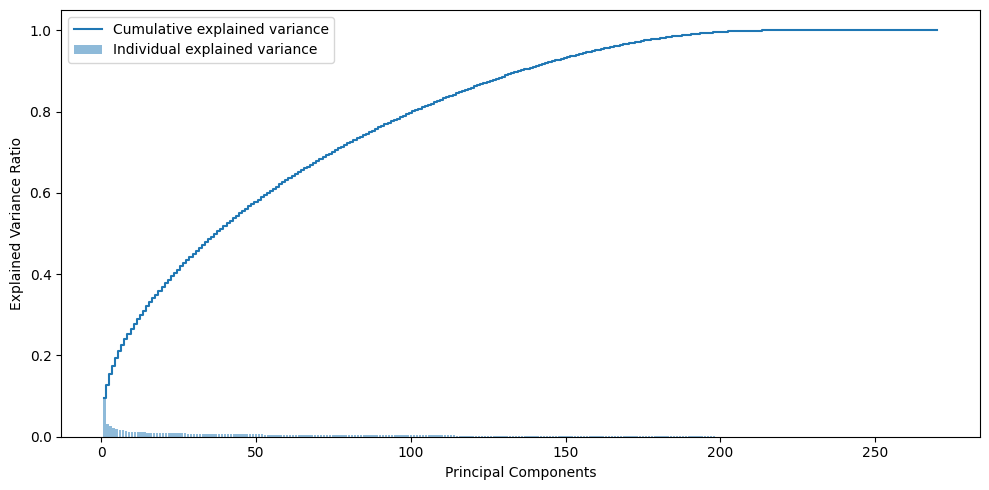

In [ ]:
## Show the explained variance for components
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10,5))
plt.bar(range(1,len(explained_variance)+1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1,len(explained_variance)+1), np.cumsum(explained_variance), where='mid', label='Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

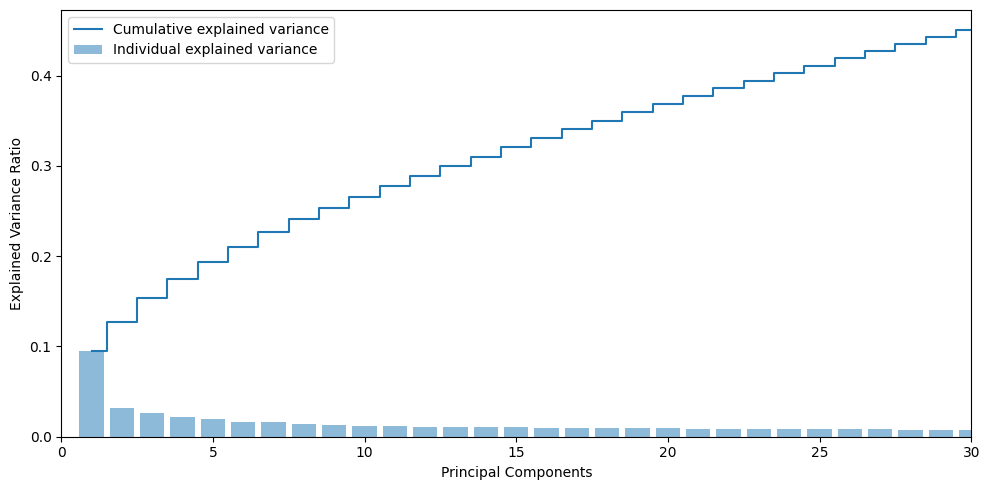

In [ ]:
## Applying ELBOW to select components
explained_variance = pca.explained_variance_ratio_[0:30]

plt.figure(figsize=(10,5))
plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(explained_variance)+1), np.cumsum(explained_variance), where='mid', label='Cumulative explained variance')

plt.xlim(0, 30)

plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
## Transfer the components into data
X_V = pd.DataFrame(X_V)
X_V.index = X.index
k = X.shape[1]
X_V.columns = ['PC' + str(i+1) for i in range(k)]
X_V

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC261,PC262,PC263,PC264,PC265,PC266,PC267,PC268,PC269,PC270
0,4.311316,1.066734,-2.626288,-2.139624,1.277933,-0.435220,0.434055,1.270078,-0.092650,-1.326774,...,1.127545e-15,6.074424e-16,4.117163e-16,3.341936e-16,-3.579363e-16,5.244013e-16,-5.754192e-16,8.965517e-15,-1.771080e-16,-4.940438e-16
1,-0.232049,-3.394771,-0.020570,-0.413394,0.549740,-0.077904,-1.150409,0.627625,1.034785,-0.078832,...,-7.843307e-16,1.255746e-16,3.036132e-15,-1.839291e-15,1.103322e-15,4.455411e-17,9.713366e-16,2.448195e-16,-3.243557e-16,1.111835e-15
2,5.273446,0.080657,-1.696076,-2.678560,2.178545,0.042026,0.107799,1.784435,-0.254292,-1.547249,...,1.512992e-15,-1.741080e-15,6.910126e-16,1.259992e-15,-5.896207e-16,-1.477587e-15,-8.949469e-16,-4.896480e-17,-8.040967e-17,9.701043e-16
3,0.381124,1.453771,3.252613,-0.730547,-0.453143,-0.331245,-2.366871,0.423673,1.721647,1.460033,...,-7.197538e-16,-9.000851e-16,-2.926565e-15,-7.760002e-16,4.571762e-16,8.641127e-16,-6.075721e-16,-9.024036e-16,3.736859e-17,1.510599e-15
4,8.874162,0.026790,0.964092,-3.439534,1.070492,-0.043831,0.786127,2.825522,0.615225,-1.848085,...,2.006789e-16,-8.759304e-16,9.412841e-16,-3.591016e-16,6.598269e-16,-2.226082e-15,2.463792e-16,-3.811190e-16,1.051579e-15,-4.110483e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.907136,1.636050,-1.509334,-3.384917,2.130149,-1.432077,1.280496,-0.871439,0.438301,0.654569,...,-5.555643e-17,1.476774e-17,-7.940179e-17,1.088491e-16,-5.058070e-16,-2.086577e-17,1.501998e-16,2.521535e-16,-5.781767e-18,-8.878699e-17
1456,0.729698,-5.828723,2.560655,-0.907306,-1.489820,0.063486,1.187528,1.021470,-1.123873,2.728537,...,-5.418116e-16,5.430497e-17,-1.629892e-16,-1.626316e-16,-3.169042e-16,1.264982e-16,2.048815e-16,5.434000e-17,-9.753994e-18,4.116088e-17
1457,0.570630,1.797859,1.926950,-2.439557,-1.148568,0.973686,-3.579770,-2.855432,-4.460186,-0.575582,...,4.641267e-18,1.216568e-17,-3.382896e-16,-5.521926e-17,4.617021e-17,1.875122e-17,9.072733e-17,-1.089279e-16,2.177606e-16,1.435336e-17
1458,-4.594755,-3.154790,-0.613408,2.307654,-0.181218,-0.761711,-2.316909,0.281021,-0.887255,-0.505876,...,-3.118584e-16,1.340243e-16,-5.048962e-17,2.850418e-17,1.601282e-16,2.554367e-16,1.302362e-16,-2.170269e-16,-9.122829e-18,2.073537e-16


In [ ]:
## Transfer the components into data
k = test_X.shape[1]
test_X_V.columns = ['PC' + str(i+1) for i in range(k)]
test_X_V

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC261,PC262,PC263,PC264,PC265,PC266,PC267,PC268,PC269,PC270
0,-3.717457,-3.627732,-0.177158,0.399264,1.295609,-2.003441,0.545287,0.504646,0.661891,2.911686,...,5.304208e-17,3.824081e-16,-1.755091e-15,3.858975e-16,-4.494072e-16,-7.026857e-16,-2.950035e-16,-6.372536e-16,-1.922759e-16,-3.132201e-15
1,-1.874081,-3.706096,1.237588,-0.464686,1.241342,-1.250850,-1.027072,-1.900680,1.358704,-1.594355,...,-1.003976e-15,6.508562e-16,-5.950678e-16,6.351485e-16,-9.745642e-16,-7.023212e-16,1.093728e-15,2.750199e-15,-1.744358e-16,1.920513e-16
2,1.989845,0.304477,-2.359554,-3.334965,0.714161,1.402545,0.710821,-0.619713,-1.454772,-2.018076,...,-7.676442e-16,-1.434910e-15,2.633644e-16,1.458330e-15,1.139658e-15,1.337015e-15,1.578136e-15,-7.569758e-16,3.485778e-16,-6.095349e-16
3,2.983894,0.742009,-1.914673,-2.420422,0.737717,0.373110,0.417617,-0.784765,-0.363575,-2.213950,...,3.016892e-15,-1.306550e-15,2.716844e-16,1.486710e-15,-7.131886e-16,1.764596e-15,-1.212742e-15,5.627836e-16,8.878260e-16,6.573235e-16
4,3.080362,-0.422668,-2.841291,2.496912,-1.204216,1.365189,-0.226456,-0.969958,-0.731037,-0.760991,...,7.967050e-17,3.391860e-16,-1.739489e-16,5.468020e-16,8.587616e-16,-2.382087e-16,-1.205221e-15,8.197969e-16,1.234588e-15,-3.817793e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,-6.903887,1.799390,-7.471261,1.706795,-5.965027,0.010994,-3.373118,-2.501625,-1.940951,-1.519216,...,-2.720869e-16,5.096392e-17,3.153492e-16,1.214813e-16,8.838493e-17,-1.211150e-16,-7.469554e-16,2.745086e-16,-5.638754e-17,-2.327689e-16
1455,-5.565823,1.126784,-5.910319,2.550895,-6.753567,-0.056508,-4.291389,-0.999948,-2.398861,-0.554234,...,-3.312680e-16,-6.932712e-18,-1.479682e-16,1.144366e-16,-1.574785e-16,-1.274312e-16,4.385067e-16,-1.761469e-16,-3.354928e-16,-1.252700e-16
1456,-0.933197,-2.206396,1.193057,-1.403790,1.580812,-1.466499,0.120607,0.602660,-1.540234,0.143434,...,-8.629984e-17,-3.801280e-16,-8.783182e-17,-1.255451e-17,9.955341e-17,1.233230e-16,4.039521e-16,2.272377e-16,6.514381e-17,1.396150e-16
1457,-4.031794,-2.456854,-4.102851,0.474827,1.221442,2.228210,-0.861274,-1.033752,-0.008537,-2.195269,...,1.565409e-16,-2.239166e-16,-2.232204e-16,1.957685e-16,-4.341673e-16,2.574427e-16,-2.292163e-17,4.397705e-16,5.142597e-17,3.441998e-17


In [ ]:
## Test the regression with first three components
# Define the model
model = smf.ols(formula='sale_price ~ PC1+PC2+PC3', data = X_V)

# Fit the model
results = model.fit()

# Convert the summary results to a DataFrame
results_summary = results.summary()
results_df = pd.DataFrame(results_summary.tables[1].data)
results_df.columns = results_df.iloc[0]
results_df = results_df.drop(0)

# Save the DataFrame to a CSV file
from google.colab import drive

drive.mount('/content/drive')
results_df.to_csv('/content/drive/MyDrive/results.csv', index=False)
print(results.summary())

Mounted at /content/drive
                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     2420.
Date:                Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                        12:07:37   Log-Likelihood:                 575.03
No. Observations:                1460   AIC:                            -1142.
Df Residuals:                    1456   BIC:                            -1121.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.0241     

## 5. Add Selected Components into Dataset

In [ ]:
X = pd.concat([numerical_df_scaled,cat_df_scaled],axis = 1)
test_X = pd.concat([numerical_df_test_scaled,cat_df_test_scaled],axis = 1)
X_scaled = pd.DataFrame(X, index=X.index, columns=X.columns)
test_X_scaled = pd.DataFrame(test_X, index=test_X.index, columns=test_X.columns)

In [ ]:
X_V = X_V.iloc[:, :3]
test_X_V = test_X_V.iloc[:, :3]
X_join = X_scaled.join(X_V)
test_X_join = test_X_scaled.join(test_X_V)

## 6. Run New Regression with Lasso

In [ ]:
lasso_cv_model = LassoCV(alphas=np.logspace(-10, 0, num=100), cv=5)
lasso_cv_model.fit(X_join, sale_price)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03713645121325726, tolerance: 0.01891259276039609
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23887069427664542, tolerance: 0.01891259276039609
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.42940195417615534, tolerance: 0.01891259276039609
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: Co

LassoCV(alphas=array([1.00000000e-10, 1.26185688e-10, 1.59228279e-10, 2.00923300e-10,
       2.53536449e-10, 3.19926714e-10, 4.03701726e-10, 5.09413801e-10,
       6.42807312e-10, 8.11130831e-10, 1.02353102e-09, 1.29154967e-09,
       1.62975083e-09, 2.05651231e-09, 2.59502421e-09, 3.27454916e-09,
       4.13201240e-09, 5.21400829e-09, 6.57933225e-09, 8.30217568e-09,
       1.04761575e-08, 1.32194115e-0...
       4.75081016e-03, 5.99484250e-03, 7.56463328e-03, 9.54548457e-03,
       1.20450354e-02, 1.51991108e-02, 1.91791026e-02, 2.42012826e-02,
       3.05385551e-02, 3.85352859e-02, 4.86260158e-02, 6.13590727e-02,
       7.74263683e-02, 9.77009957e-02, 1.23284674e-01, 1.55567614e-01,
       1.96304065e-01, 2.47707636e-01, 3.12571585e-01, 3.94420606e-01,
       4.97702356e-01, 6.28029144e-01, 7.92482898e-01, 1.00000000e+00]),
        cv=5)

In [ ]:
# The optimal alpha selected by lasso cross-validation
optimal_alpha = lasso_cv_model.alpha_
print("Optimal Alpha:", optimal_alpha)

Optimal Alpha: 0.0037649358067924636


In [ ]:
## Predict with Lasso
lasso_model = Lasso(alpha=optimal_alpha)
lasso_model.fit(X_join, sale_price)
lasso_predictions = lasso_model.predict(test_X_join)
lasso_predictions = np.expm1(lasso_predictions)
lasso_predictions

array([122173.27126795, 161154.96715719, 185499.87268449, ...,
       166336.10733016, 120482.9938073 , 229262.13359251])

In [ ]:
lasso_coefficients = lasso_model.coef_
final_features = X_join.columns.tolist()

feature_names = final_features

lasso_coeff_df =  pd.DataFrame({'Feature': feature_names, 'Lasso Coefficient': lasso_coefficients})


In [ ]:
# Create an interactive scatter plot using Plotly
fig = px.scatter(lasso_coeff_df, x='Feature', y=['Lasso Coefficient'],
                 title='Lasso Coefficients', labels={'value': 'Coefficient'})

# Customize layout
fig.update_layout(xaxis={'tickangle': -45, 'title': 'Feature'},
                  yaxis={'title': 'Coefficient'})
fig.update_yaxes(range=[-0.1, 0.1])  # Adjust the range as needed

# Show the interactive plot
fig.show()

In [ ]:
#Generate the submission file
sample_submission_df = pd.read_csv('https://www.dropbox.com/scl/fi/fxiwfe47v7odz6qdukl0h/sample_submission.csv?rlkey=v8eknwjn58j9t0v9wu856yx6c&dl=1')
sample_submission_df['SalePrice'] = lasso_predictions
sample_submission_df.to_csv('/content/drive/MyDrive/Assignment 5.csv', index=False)